[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fvalerii/geospatial-land-classification/blob/main/notebooks/03_hybrid_transformer_integration/07_keras_vision_transformer.ipynb)

# 🛰️ 07: Hybrid CNN-Vision Transformer Integration (Keras)
### Geospatial Land Classification Study (Hybrid Phase)
(*This is the 7th module in a 9-part series exploring geospatial hybrid models.*)

### 🧪 Methodology & Technical Objectives
This research module implements a **Hybrid CNN-Vision Transformer (ViT)** architecture. By utilizing the CNN baseline developed in Module 04 as a feature extractor, we provide the Transformer with a pre-conditioned spatial hierarchy. This "Best of Both Worlds" approach aims to capture both local geometric features (via Convolutions) and global contextual relationships (via Self-Attention).

**Key Technical Focus:**
* **Feature-to-Token Mapping:** Reshaping multi-channel convolutional feature maps into a sequential input suitable for Attention blocks.
* **Stochastic Attention Mechanism:** Implementing Multi-Head Self-Attention (MHSA) to weight the significance of different spatial patches in the satellite tile.
* **Learnable Positional Embeddings:** Injecting spatial context into the flattened tokens to preserve coordinate integrity.
* **Integrated Hybrid Benchmarking:** Training the combined architecture to determine if global attention provides a performance delta over purely local CNN baselines.

## Introduction

This research module builds an integrated CNN-Vision Transformer (ViT) hybrid image classification model. Starting from an existing CNN that is good at recognizing small patterns in pictures, the model is improved with a transformer, that helps it capture wider and more complex relationships in an image.

## Table of contents

<font size = 3> 
    
1. [Implementation Environment & Dependency Management](#Implementation-Environment-&-Dependency-Management)
2. [Data Ingestion & Transformation Pipeline](#Data-Ingestion-&-Transformation-Pipeline)
3. [Baseline Model Loading and Setup](#Baseline-Model-Loading-and-Setup)
4. [Custom Positional Embedding Implementation](#Custom-Positional-Embedding-Implementation)
5. [Transformer Block Implementation](#Transformer-Block-Implementation)
6. [Hybrid Model Builder Function](#Hybrid-Model-Builder-Function)
7. [Callbacks Setup](#Callbacks-Setup)
8. [Model Training and Evalation](#Model-Training-and-Evaluation)

</font> 


## Implementation Environment & Dependency Management

In [ ]:
import os, sys

# --- Universal Environment Setup ---
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Use the fast local runtime disk for satellite imagery
    BASE_DIR = '/content/'
    os.chdir(BASE_DIR)
    
    # Install specific versions for vit-research environment stability
    !pip install numpy==1.26.0 matplotlib==3.9.2 pandas==2.2.3 tensorflow==2.19\
        scikit-learn==1.7.0 requests tqdm==4.66.5 gdown Pillow --quiet
    
    print(f"✅ Environment: Google Colab. In-memory data loading will use: {BASE_DIR}")
else:
    # Local System (relative to the notebook folder)
    BASE_DIR = './' 
    print(f"✅ Environment: Local System. Directory: {os.getcwd()}")

In [2]:
# Set up a quiet environment for TensorFlow and Keras operations
import warnings, logging

# --- 1. System & Library Silence ---
# '3' to only display error messages from its C++ backend.
# This reduces verbose output and keeps the console cleaner, focusing on more critical information during model training.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# '0' disables verbose logging about optimizations and precision details.
os.environ['TF_CPP_MAX_VLOG_LEVEL'] = '0' 
# "0" to disable Intel oneDNN optimizations, which can sometimes lead to issues or unwanted behavior on specific hardware configurations.
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0' 

# --- 2. Python Warning Suppression ---
# Ignore standard warnings (e.g., deprecated functions in TFP or Matplotlib).
warnings.filterwarnings('ignore')

### Framework & Optimization Utilities

In [ ]:
%%time
# --- Common Imports ---
import time
from datetime import datetime
def present_time():
        return datetime.now().strftime('%Y%m%d_%H%M%S')
import requests, tarfile, gdown
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- TensorFlow and Keras Imports ---
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
print("Succesfully imported the libraries")

### Hardware Acceleration & GPU Utilization
Check the availability of GPU

In [4]:
# GPU Detection and Specification
# 1. Check if TensorFlow detects the GPU
device_name = tf.test.gpu_device_name()

if not device_name:
    print('❌ GPU device not found.')
    print('💡 Recommendation: If in Colab, go to Runtime > Change runtime type and select "T4 GPU" for significantly faster training.')
else:
    print(f'✅ Found GPU at: {device_name}')

    # 2. Identify the specific GPU model ONLY if detected
    print('\nHardware Specifications:')
    !nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

✅ Found GPU at: /device:GPU:0

Hardware Specifications:


I0000 00:00:1771162809.986645   58040 gpu_device.cc:2019] Created device /device:GPU:0 with 5578 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


name, driver_version, memory.total [MiB]
NVIDIA GeForce RTX 3070 Laptop GPU, 591.44, 8192 MiB


### Reproducibility with random seeds

The random seeds for `random` module, NumPy, and TensorFlow are assigned a fixed value. By initializing these seeds with a constant value (for example, 42), any operations that involve randomness (such as weight initialization, data shuffling, or data augmentation) will produce the exact same sequence of random numbers every time the code is run. This is crucial for ensuring the reproducibility of experimental results and when comparing different models or hyperparameters.


In [5]:
# Define a function to set seeds for reproducibility
def set_reproducibility(seed=42):
    """
    Sets the global random seeds to ensure reproducible results across runs.
    
    Args:
        seed (int): The seed value to use for all random number generators.

    Returns:
        None
    """
    # 1. Set Python core random seed
    random.seed(seed)

    # 2. Set Python environment seed for hash-based operations
    os.environ['PYTHONHASHSEED'] = str(seed)

    # 3. Set NumPy seed (used for data shuffling and matrix ops)
    np.random.seed(seed)

    # 4. Set TensorFlow seed (used for weight initialization)
    tf.random.set_seed(seed)

    # 5. Force TensorFlow to use deterministic algorithms (Optional)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

    print(f"Reproducibility set with seed: {seed}")

# Execute the seeding
set_reproducibility(42)

Reproducibility set with seed: 42


## Data Ingestion & Transformation Pipeline
The dataset is fetched directly from the public IBM Cloud Object Storage. To ensure local reproducibility and bypass proprietary library dependencies, a standard Python pipeline using `requests` and `tarfile` is implemented for automated artifact retrieval and decompression.

In [6]:
# --- Data Ingestion Configuration ---
# Matches your existing path logic: base_dir = os.path.join(extract_dir, 'images_dataSAT')
DATA_URL = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/5vTzHBmQUaRNJQe5szCyKw/images-dataSAT.tar"
TAR_FILE = os.path.join(BASE_DIR, "images-dataSAT.tar")
# For simplicity extract to the base directory.
EXTRACT_PATH = BASE_DIR

def download_and_extract(url, destination, extract_to):
    """
    Handles automated retrieval and decompression. 
    Optimized to land data directly into the project root.

    Args:
        - url (str): The URL to download the dataset from.
        - destination (str): The local file path where the downloaded archive will be saved.
        - extract_to (str): The directory where the contents of the archive will be extracted.
    
    Returns:
        None
    """
    # 1. Streamed Download
    if not os.path.exists(destination):
        print(f"🛰️ Downloading archive to: {destination}")
        response = requests.get(url, stream=True)
        total_size = int(response.headers.get('content-length', 0))
        
        with open(destination, "wb") as f, tqdm(
            desc="Downloading Dataset",
            total=total_size,
            unit='iB', unit_scale=True, unit_divisor=1024,
        ) as bar:
            for data in response.iter_content(chunk_size=1024):
                size = f.write(data)
                bar.update(size)
    else:
        print(f"✅ Archive already exists.")

    # 2. Extraction 
    expected_folder = os.path.join(extract_to, 'images_dataSAT')
    if not os.path.exists(expected_folder):
        print(f"📦 Extracting dataset to: {extract_to}")
        with tarfile.open(destination, "r") as tar:
            tar.extractall(path=extract_to)
        print("🚀 Extraction complete.")
    else:
        print(f"✅ Dataset folder '{expected_folder}' already verified.")

# Run the ingestion
download_and_extract(DATA_URL, TAR_FILE, EXTRACT_PATH)

✅ Archive already exists.
✅ Dataset folder './images_dataSAT' already verified.


### 📂 Directory Hierarchy and Class Mapping. The dataset follows a standard categorical sub-directory structure, enabling automated class inference for agricultural and non-agricultural classification.

```python
images_dataSAT/
├── class_0_non_agri/
└── class_1_agri/

```

**class_0_non_agri** is the non-agricultural land class, as defined earlier, and it represents images with non-cultivable land. 

**class_1_agri**, on the other hand, is the agricultural land class, and it represents the images with cultivable land.

In [7]:
# Define directories
dataset_path = os.path.join(EXTRACT_PATH, 'images_dataSAT')
# Note: It's common practice for class directories to have clear names.
# Using 'class_0' and 'class_1' is good for automatic inference.
dir_non_agri = os.path.join(dataset_path, 'class_0_non_agri')
dir_agri = os.path.join(dataset_path, 'class_1_agri')

print(f"Dataset path: {dataset_path}")
print(f"Non-agricoltural images directory: {dir_non_agri}")
print(f"Agricoltural images directory: {dir_agri}")

Dataset path: ./images_dataSAT
Non-agricoltural images directory: ./images_dataSAT/class_0_non_agri
Agricoltural images directory: ./images_dataSAT/class_1_agri


### Pandas DataFrame creation

A Pandas DataFrame **`df`** of all images and their class is created by recursively scanning through the `dataset_path` using `os.walk` function. 

The total count of files found is printed and the first two and last two file paths are displayed for verifcation purposes. 

The absolute path is captured using `os.path.join(dirname, filename)` and used in `ImageDataGenerator` later.


In [8]:
# Create pandas dataframe of images file paths and corresponding labels
rows = []
for dir_name, _, file_names in os.walk(dataset_path):
    for file_name in file_names:
        if file_name.lower().endswith("jpg"):
            full_path = os.path.join(dir_name, file_name)
            label = os.path.basename(dir_name)
            rows.append((full_path, label))

df = pd.DataFrame(rows, columns=["filename", "class"])

# Print count of files found and some examples of files
print(f'Total files in dataset: {len(df)}')
print(f'First two paths:\n {df.iloc[:2, 0]}\n')
print(f'Last two paths:\n {df.iloc[-2:, 0]}\n')


Total files in dataset: 6000
First two paths:
 0    ./images_dataSAT/class_1_agri/tile_S2A_MSIL2A_...
1    ./images_dataSAT/class_1_agri/tile_S2A_MSIL2A_...
Name: filename, dtype: object

Last two paths:
 5998    ./images_dataSAT/class_0_non_agri/tile_S2A_MSI...
5999    ./images_dataSAT/class_0_non_agri/tile_S2A_MSI...
Name: filename, dtype: object



In [9]:
# Split train, validation and test dataframes 80/10/10
train_val_df, test_df = train_test_split(
    df, test_size=0.10, random_state=42, stratify=df["class"]
)

train_df, val_df = train_test_split(
    train_val_df, test_size=0.111, random_state=42, stratify=train_val_df["class"]
)

### Definition of model hyperparameters

This cell initializes several key **hyperparameters** that will govern the training process and the model's input. Here is the list of hyperparameters:

- `img_w` and `img_h` defines the width and height for resizing input images.
-  `n_channels` defines the number of color channels (3 for RGB)
- `batch_size` sets the number of samples processed per batch in the epoch.
- `epochs` sets the total training iterations over the dataset.
- `learning_rate` defines the learning rate for the optimizer.

- `steps_per_epoch` are total number of steps used for training. **None** means the number is calculated automatically.
- `validation_steps` are total number of steps used for validating the model on validation data. **None** means the number is calculated automatically.

These hyperparameters are crucial for controlling model performance and resource utilization and significantly influence a model's performance and training efficiency. 

In [10]:
# Image dimensions and channels for model input
img_w, img_h = 64, 64
n_channels = 3
batch_size = 32

epochs = 20
learning_rate = 1e-4 # Learning rate
attn_heads = 8 # Number of heads of the Multi-Head Self-Attention (MHSA) Layer
depth = 4 # Number of Transformer Blocks.
embed_dim  = 256
mlp_dim = 4 * embed_dim

steps_per_epoch = None
validation_steps = None 

### Implementation of `ImageDataGenerator` for Augmentation

The data preprocessing and augmentation pipeline is defined using Keras' `ImageDataGenerator` using the following parameters:

- `rescale=1./255` normalizes pixel values to [0, 1].
- `rotation_range`, `width_shift_range`, `height_shift_range`, `shear_range`, and `zoom_range` define random transformations to apply to images during training, increasing dataset diversity.
- `horizontal_flip=True` enables random horizontal mirroring.
- `fill_mode='nearest'` specifies how new pixels are filled after transformations.

This augmentation strategy significantly increases the effective dataset size and helps prevent overfitting by exposing the model to varied versions of the same images. The validation split ensures proper model evaluation on unseen data, while the categorical class mode prepares labels for softmax classification in the hybrid model.

This setup boosts model robustness against variations in real-world images. `ImageDataGenerator` performs these transformations on-the-fly, making it efficient for large datasets. 


In [11]:
# --- Data Augmentation Configuration ---
train_datagen = ImageDataGenerator(rescale=1./255, # Nornamlize pixel values to [0, 1]
                             rotation_range=40, 
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode="nearest"
                            )

test_datagen = ImageDataGenerator(rescale=1./255)

### Initialization of training, validation, and test data generators

Three separate generators are created:
1. `train_gen`: Training data with augmentation and shuffling
2. `val_gen`: Validation data with the same preprocessing but a different subset
3. `test_gen`: Test data for final evaluation of the model

All generators use `class_mode="categorical"` for one-hot encoded labels, `target_size=(64,64)` for consistent input dimensions, and only `train_generator` uses `shuffle=True` for randomized batch sampling.

The test data is used as holdout data for final evaluation of the model after the training has been completed and the best weights have been selected.
 
 `flow_from_dataframe()` is a convenient method of `ImageDataGenerator` for automatically creating data pipelines from a pandas dataframe.


In [12]:
# Initialize the training data generator
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="filename", y_col="class",
    target_size=(img_w, img_h),
    batch_size=batch_size,
    class_mode="categorical"
)

Found 4800 validated image filenames belonging to 2 classes.


In [13]:
# Initialize the validation data generator
validation_generator = test_datagen.flow_from_dataframe(
    val_df,
    x_col="filename", y_col="class",
    target_size=(img_w, img_h),
    batch_size=batch_size,
    class_mode="categorical"
)

Found 600 validated image filenames belonging to 2 classes.


In [14]:
# Initialize the test data generator
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col="filename", y_col="class",
    target_size=(img_w, img_h),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 600 validated image filenames belonging to 2 classes.


### Implementstion Steps
1. Loading a pre-trained Convolutional Neural Network (CNN) to act as a robust feature extractor for your image dataset.
2. Selection an intermediate feature map and reshape it into a sequence of tokens, getting the data ready for transformer-based learning.
3. Addition custom positional embeddings to the tokens so that the model can retain the original spatial structure of the images, even after the features have been flattened.
4. Implementation of a Vision Transformer (ViT) encoder by stacking several transformer blocks, allowing the model to learn global relationships and context throughout the image.
5. Combination of the CNN and ViT encoder into a single, hybrid model so that can be leverage both the local feature extraction power of CNNs and the global attention mechanism of transformers.
6. Use of Keras’s ImageDataGenerator to handle data augmentation and to properly encode labels for multi-class image classification.
7. Set up a model checkpoint callback, letting the model to automatically save its best weights whenever validation accuracy improves during training, allowing to keep the most effective model.
8. Architecture consistency verification by hecking the input and output shapes, to catch architectural mistakes early.
9. Visualization of both training and validation accuracy and loss, to monitor performance and spot signs of overfitting or underfitting.

### Download Model weights

📦 Model Persistence Note: Due to GitHub's file size constraints, the pre-trained weights for the Keras and PyTorch baselines are hosted externally. The evaluation pipelines in this module include automated fetching logic to ensure seamless reproducibility.

In [15]:
# --- Artifact Management: Remote Weight Restoration ---
def restore_model_artifacts():
    """
    Downloads pre-trained weights from remote storage if not localized.
    Ensures reproducibility for users without requiring local training phases.
    """
    artifacts = {
        "cnn_keras_best.keras": "1oiVHiB-qNOUmBL0NRo6XCl1eSZDNQujD",
        #"cnn_pytorch_best.pth": "1BjOuHiZJlbi7UbJHYhwWBmHjj5jQQ6sC" # This line will be used in the next module for the PyTorch phase.
    }
    
    # Check if we are in Colab to use gdown efficiently
    try:
        for filename, file_id in artifacts.items():
            if not os.path.exists(filename):
                print(f"📡 Fetching {filename} from remote storage...")
                url = f'https://drive.google.com/uc?export=download&id={file_id}'
                gdown.download(url, filename, quiet=False)
            else:
                print(f"✅ {filename} is already localized.")
    except Exception as e:
        print(f"⚠️ Artifact restoration failed: {e}")

restore_model_artifacts()

✅ cnn_keras_best.keras is already localized.


In [16]:
cnn_model_path = "cnn_keras_best.keras"

print(f"✅ Model paths set:\n - Keras: {cnn_model_path}")

✅ Model paths set:
 - Keras: cnn_keras_best.keras


## Baseline Model Loading and Setup

The `load_model()` function loads the complete Keras model, including architecture, weights, and compilation state. The loaded model serves as the CNN backbone for feature extraction in the hybrid architecture. The `cnn_model.summary()` allows to inspect the model architecture and identify appropriate layers for feature extraction.

In [17]:
# Load pre-trained CNN model and print model summary
cnn_model = load_model(cnn_model_path)
cnn_model.summary()


I0000 00:00:1771162810.590658   58040 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5578 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 512)      │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2, 2, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 2, 2, 1024)     │    13,108,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1, 1, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 61,034,501 (232.83 MB)

 Trainable params: 20,340,801 (77.59 MB)

 Non-trainable params: 12,096 (47.25 KB)

 Optimizer params: 40,681,604 (155.19 MB)

Based on `model.summary()`, we assign the name of the layer from the CNN model for feature extraction to the variable `feature_layer_name`

The layer choosen is `conv2d_3` which has an $8 \times 8 \times 256$ feature map that provide a balance between spatial resolution and semantic depth. By using 64 tokens, the Transformer models global dependencies across the entire satellite tile without the quadratic memory explosion of the raw $32 \times 32$ maps. Choosing the 256-channel layer ensured the tokens had sufficient dimensionality to represent complex land-cover features.


In [18]:
# Assign to a variable the name of last layer before GlobalAveragePooling2D
feature_layer_name = 'conv2d_3'

# Extract the shape from the output tensor
layer_output = cnn_model.get_layer(feature_layer_name).output
layer_shape = layer_output.shape

embed_dim = layer_shape[3]

print(f"🔍 Layer Verification: {feature_layer_name}")
print(f"Full Output Shape: {layer_shape}")
print(f"---")
print(f"Spatial Grid: {layer_shape[1]} x {layer_shape[2]}")
print(f"Sequence Length (Tokens): {layer_shape[1] * layer_shape[2]}")
print(f"Embedding Dimension: {layer_shape[3]}")

🔍 Layer Verification: conv2d_3
Full Output Shape: (None, 8, 8, 256)
---
Spatial Grid: 8 x 8
Sequence Length (Tokens): 64
Embedding Dimension: 256


## Custom Positional Embedding Implementation

Definition of a custom Keras layer called `AddPositionEmbedding` that implements positional embeddings for the Vision Transformer architecture. Positional embeddings are crucial in transformer models because they lack inherent spatial awareness, unlike convolutional layers that have built-in spatial inductive biases.

- The class inherits from `layers.Layer`, making it a proper Keras custom layer
- In the `__init__` method, it creates a trainable weight matrix using `self.add_weight()`
- The positional embedding has shape `(1, num_patches, embed_dim)` where the first dimension allows broadcasting across batch sizes
- The `initializer="random_normal"` ensures the embeddings start with random values that will be learned during training
- The `trainable=True` parameter makes these embeddings learnable parameters


This layer is essential for the hybrid CNN-ViT architecture because the CNN extracts spatial feature maps, but when these maps are flattened into a sequence of tokens for the transformer, the explicit 2D spatial structure is lost. The positional embedding layer reintroduces spatial information by assigning each token an embedding that encodes its original location in the feature map. This allows the transformer to understand spatial relationships—such as which tokens were neighbors or far apart—so it can perform spatially coherent attention.

The `call` method adds the positional embeddings to the input tokens using element-wise addition. This is computationally efficient and follows the standard transformer approach, where positional information is added to preserve the embedding dimension.


In [19]:
# Positional embedding that Keras can track
@tf.keras.utils.register_keras_serializable(package="Custom")
class AddPositionEmbedding(layers.Layer):
    def __init__(self, num_patches, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.embed_dim   = embed_dim
        self.pos = self.add_weight(
            name="pos_embedding",
            shape=(1, num_patches, embed_dim),
            initializer="random_normal",
            trainable=True)

    def call(self, tokens):
        return tokens + self.pos

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_patches": self.num_patches,
            "embed_dim":   self.embed_dim,
        })
        return {**config}

## Transformer Block Implementation

Implementation of a complete transformer encoder block, the fundamental building block of the Vision Transformer architecture. The `TransformerBlock` class encapsulates the standard transformer encoder architecture with multi-head self-attention and feed-forward neural network components.

**Role in hybrid architecture:**
In the CNN-ViT hybrid, these transformer blocks process the tokenized CNN feature maps, allowing the model to capture long-range spatial dependencies that CNNs might miss due to their limited receptive fields. The self-attention mechanism enables each spatial location to attend to all other locations, providing global context awareness.

**Technical architecture:**
- **Multi-head attention (MHA):** Uses `layers.MultiHeadAttention` with a configurable number of heads and key dimension equal to embed_dim
- **Layer normalization:** Two `LayerNormalization` layers with epsilon=1e-6 for numerical stability
- **MLP block:** A two-layer feed-forward network with GELU activation and dropout for regularization
- **Residual connections:** Implements skip connections around both the attention and MLP blocks

**Parameters:**
- `embed_dim`: The dimensionality of token embeddings (typically matches CNN feature map channels)
- `num_heads`: Number of attention heads (default 8, must divide embed_dim evenly)
- `mlp_dim`: Hidden dimension of the MLP block (default 1024, typically 4x embed_dim)
- `dropout`: Dropout rate for regularization (default 0.1)

**Forward pass logic:**
Forward pass allows the model to capture both local and global dependencies in the feature representations while maintaining gradient flow through residual connections.


In [20]:
# One Transformer encoder block
@tf.keras.utils.register_keras_serializable(package="Custom")
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads=8, mlp_dim=1024, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.mlp_dim   = mlp_dim
        self.dropout   = dropout
        self.mha  = layers.MultiHeadAttention(num_heads, key_dim=embed_dim // num_heads)
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.mlp = Sequential([
            Dense(self.mlp_dim, activation="gelu"),
            Dropout(self.dropout),
            Dense(self.embed_dim),
            Dropout(self.dropout)
        ])

    def call(self, x):
        x_norm = self.norm1(x)
        attn_output = self.mha(x_norm, x_norm)
        x = x + attn_output

        x_norm = self.norm2(x)
        mlp_output = self.mlp(x_norm)
        return x + mlp_output

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim":  self.embed_dim,
            "num_heads":  self.num_heads,
            "mlp_dim":    self.mlp_dim,
            "dropout":    self.dropout,
        })
        return {**config}


## Hybrid Model Builder Function

Definition of a function `build_cnn_vit_hybrid` that constructs the complete hybrid CNN-Vision Transformer model. This function combines the strengths of convolutional neural networks for local feature extraction with transformers for global context modeling.

**Function architecture:**
1. **CNN feature extraction:** Extracts intermediate feature maps from a pre-trained CNN at a specified layer
2. **Tokenization:** Reshapes spatial feature maps into a sequence of tokens suitable for transformer processing
3. **Positional encoding:** Adds learnable positional embeddings to maintain spatial relationships
4. **Transformer stack:** Applies multiple transformer encoder blocks for global context modeling
5. **Classification head:** Pools tokens and applies the final classification layer

**Parameters:**
- `cnn_model`: Pre-trained CNN model for feature extraction
- `feature_layer_name`: Name of the CNN layer to extract features from (e.g., `conv2d_3` in the original model architecture)
- `num_transformer_layers`: Number of transformer blocks to stack (default 8)
- `num_heads`: Number of attention heads per transformer block (default 8)
- `mlp_dim`: MLP hidden dimension in transformer blocks (default 1024)
- `num_classes`: Number of output classes for classification (default 2)

The function first freezes the CNN backbone (`cnn_model.trainable = False`) to use it as a fixed feature extractor. It then extracts feature maps with shape (B, H, W, C) and reshapes them to (B, H*W, C), where each spatial location becomes a token. The `AddPositionEmbedding` layer adds spatial awareness, and multiple TransformerBlock layers process the tokens. Finally, `GlobalAveragePooling1D` aggregates all tokens, and a dense layer with softmax activation produces class predictions.

This hybrid approach leverages CNN's local feature detection capabilities while adding the transformer's global attention mechanism. The result is a model that can capture both fine-grained local patterns and long-range spatial dependencies, potentially **outperforming pure CNN** or pure transformer approaches on vision tasks.


In [21]:
def build_cnn_vit_hybrid(
        cnn_model,
        feature_layer_name,
        num_transformer_layers=8,
        num_heads=8,
        mlp_dim=1024,
        num_classes=2):
    # 1. Freeze the CNN
    cnn_model.trainable = False      # set True to fine-tune
    
    # 2. Feature extractor up to the chosen layer
    features = cnn_model.get_layer(feature_layer_name).output
    H, W, C = features.shape[1], features.shape[2], features.shape[3]
    
    # 3. Flatten spatial grid → tokens  &  add positional encoding
    x = layers.Reshape((H * W, C))(features) 
    x = AddPositionEmbedding(H * W, C)(x)

    # 4. Stack ViT encoder blocks
    for _ in range(num_transformer_layers):
        x = TransformerBlock(C, num_heads, mlp_dim)(x)

    # 5. Token pooling & classification head
    x = layers.GlobalAveragePooling1D()(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    return Model(cnn_model.layers[0].input, outputs, name="CNN_ViT_hybrid")


**Technical Note: Convolutional Tokenization**

Unlike a standard ViT which extracts $16 \times 16$ raw pixel patches, this hybrid model extracts tokens from the final CNN feature map. Given an input of $64 \times 64$, the CNN reduces the spatial resolution to a grid (e.g., $4 \times 4$), which are then treated as $N=16$ high-level semantic tokens. This allows the Attention mechanism to operate on "objects" rather than raw pixels.

## Callbacks Setup

This code cell configures a `ModelCheckpoint` callback for saving the best model weights during training. Model checkpointing is a crucial practice in deep learning that prevents loss of training progress and enables recovery of the best-performing model state.

**Checkpoint configuration:**
- `filepath`: Specifies the file path and name for saving weights
- `save_weights_only=True`: Saves only model weights, not the full model architecture (more efficient and avoids serialization issues)
- `monitor='val_accuracy'`: Tracks validation accuracy as the metric for determining the "best" model
- `mode='max'`: Indicates that higher validation accuracy values are better ('min' for loss metrics)
- `save_best_only=True`: Only saves the model when validation accuracy improves, preventing storage of worse-performing checkpoints
- `verbose=1`: Provides console output when a checkpoint is saved

The checkpoint callback addresses several important training considerations:
1. **Overfitting prevention:** Captures the model state at peak validation performance before overfitting occurs
2. **Storage efficiency:** Saving weights only reduces file size compared to full model serialization
3. **Automatic model saving:** Eliminates manual monitoring by automatically saving the best-performing epoch

**Integration with training:**
This callback will be passed to the `model.fit()` method, where it will monitor validation accuracy after each epoch. When validation accuracy improves, the callback saves the current model weights to the specified file. This ensures that even if training continues past the optimal point, the best-performing weights are preserved.

Additionally an `EarlyStopping` and `ReduceLROnPlateau` callbacks have been implemented to optimize training time and convergence. 

In [22]:
hybrid_model_path = "hybrid_keras_best.weights.h5"
# Save only weights to overcome the serialization issues with the hybrid model. The full model can be saved using the model architecture and weights.
checkpoint_cb = ModelCheckpoint(filepath=hybrid_model_path,
                                save_weights_only=True,  # Set to True to save only weights
                                monitor='val_accuracy',  # or 'val_loss'
                                mode='max',              # 'min' for loss, 'max' for accuracy
                                save_best_only=True,
                                verbose=1
                               )

callbacks = [
    checkpoint_cb,
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

## Model Training and Evaluation

Set up of the core training pipeline, where the hybrid CNN-ViT model is built, compiled, and trained. This is the complete workflow from model instantiation to training execution with proper configuration for multi-class classification.


### Model architecture definition in a variable named `hybrid_model` using the `build_cnn_vit_hybrid` function
The following parameters have been used:

- feature_layer_name: feature_layer_name
- num_transformer_layers: 8
- attention heads: 8
- mlp dimension: 1024
- num_classes: extract from training data generator (train_gen.num_classes)


In [23]:
# Instantiate the model through function build_cnn_vit_hybrid
num_classes = len(train_generator.class_indices)
hybrid_model = build_cnn_vit_hybrid(
        cnn_model,
        feature_layer_name=feature_layer_name,
        num_transformer_layers=depth,
        num_heads=attn_heads,
        mlp_dim=mlp_dim,
        num_classes=num_classes)


### Compile the model `hybrid_model` 

The following parameters have been used:
- `optimizer=tf.keras.optimizers.Adam`
- `learning rate: defined in hyperparameers section`
- `loss: categorical_crossentropy`
- `metrics: accuracy`


In [24]:
# Compile model
hybrid_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

### Model shape validation

This code cell performs the validation step to ensure the hybrid model produces outputs with the correct shape and dimensions. Shape validation is essential in deep learning to catch architectural errors early and verify that the model will work correctly with the expected input and output formats.

**Validation process:**
The cell creates a dummy input tensor using `tf.random.normal([1, img_w, img_h, n_channels])`, which generates random values with the same shape as actual input images:
- Batch size: 1 (single sample for testing)
- Width: `img_w` (64 pixels)
- Height: `img_h` (64 pixels)
- Channels: `n_channels` (3 for RGB)

**Output verification:**
The dummy input is passed through the hybrid model (`hybrid_model(dummy)`) to generate predictions. The expected output shape should be `(1, num_classes)` where:
- First dimension (1): Batch size
- Second dimension (`num_classes`): Number of classification classes

**Technical benefits:**
This validation step serves multiple purposes:
1. **Architecture verification:** Confirms that all layers are properly connected and compatible
2. **Dimension checking:** Ensures the model produces the expected output shape for classification
3. **Early error detection:** Catches shape mismatches before actual training or inference
4. **Model readiness:** Verifies the model is ready for production use

**Importance:**
If the output shape doesn't match expectations, it indicates potential issues in the hybrid architecture, such as incorrect reshaping operations, wrong number of classes configuration, or problems in the CNN-to-transformer transition. This simple test can save significant debugging time by catching architectural issues immediately after model construction.


In [25]:
# Ensure end-to-end shapes line up
dummy = tf.random.normal([1, img_w, img_h, n_channels])
pred  = hybrid_model(dummy)
print("Logits shape:", pred.shape)   # should be (1, num_classes)


I0000 00:00:1771162813.324842   58040 cuda_dnn.cc:529] Loaded cuDNN version 90600


Logits shape: (1, 2)


### Training of the `hybrid_model`.

The model has been trained for 20 epochs.

In [ ]:
## Train hybrid model using fit() method
fit = hybrid_model.fit(train_generator,
                       epochs=epochs,
                       validation_data=validation_generator,
                       callbacks=callbacks
)

In [27]:
# --- Final Training Summary ---
print(f"\n{'='*30}")
print(f"🚀 HYBRID MODEL PEAK PERFORMANCE")
print(f"{'='*30}")
print(f"Peak Validation Accuracy: {max(fit.history['val_accuracy']):.4f}")
print(f"Minimum Validation Loss:  {min(fit.history['val_loss']):.4f}")
print(f"{'='*30}")


🚀 HYBRID MODEL PEAK PERFORMANCE
Peak Validation Accuracy: 1.0000
Minimum Validation Loss:  0.0034


### Training results visualization

This code cell creates comprehensive visualizations of the training process by plotting both accuracy and loss curves. Visualization of training metrics is essential for understanding model performance, diagnosing training issues, and making informed decisions about model optimization.

**Visualization setup:**
The cell uses matplotlib to create two separate plots with consistent styling:
- `fig_w, fig_h`: Sets figure dimensions for compact, readable plots
- `plt.subplots(figsize=(fig_w, fig_h))`: Creates a subplot with specified dimensions

**Accuracy plot analysis:**
The first plot displays training and validation accuracy over epochs:
- `fit.history['accuracy']`: Training accuracy progression
- `fit.history['val_accuracy']`: Validation accuracy progression

**Loss plot analysis:**
The second plot shows training and validation loss curves:
- `fit.history['loss']`: Training loss progression
- `fit.history['val_loss']`: Validation loss progression

***Importance:***
These plots enable several important analyses:
1. **Overfitting detection:** Diverging training and validation curves indicate overfitting
2. **Convergence assessment:** Plateauing curves suggest training completion
3. **Learning rate evaluation:** Oscillating curves may indicate learning rate issues
4. **Model performance:** Final accuracy and loss values indicate overall model quality


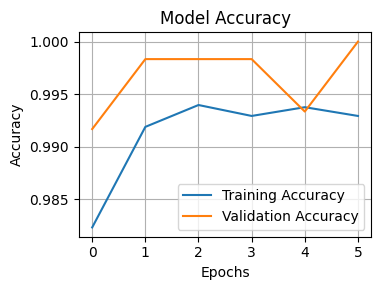

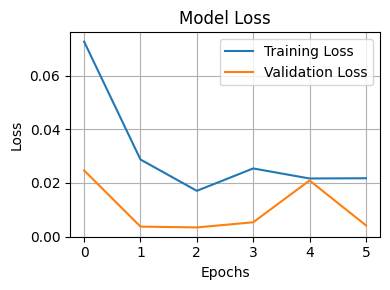

In [28]:
fig_w, fig_h = 4, 3
fig, axs = plt.subplots(figsize=(fig_w, fig_h ))

# Plot Accuracy on the first subplot
axs.plot(fit.history['accuracy'], label='Training Accuracy')
axs.plot(fit.history['val_accuracy'], label='Validation Accuracy')
axs.set_title('Model Accuracy')
axs.set_xlabel('Epochs')
axs.set_ylabel('Accuracy')
axs.legend()
axs.grid(True)

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(figsize=(fig_w, fig_h ))

# Plot Loss on the second subplot
axs.plot(fit.history['loss'], label='Training Loss')
axs.plot(fit.history['val_loss'], label='Validation Loss')
axs.set_title('Model Loss')
axs.set_xlabel('Epochs')
axs.set_ylabel('Loss')
axs.legend()
axs.grid(True)

plt.tight_layout()
plt.show()

---
**Module 07 Conclusion:** This module successfully integrated the Keras CNN backbone with a Transformer encoder. By converting spatial feature maps into semantic tokens, we allowed the model to leverage **Global Self-Attention** for final classification.

The hybrid architecture weights have been persisted. In **Module 09 (The Grand Finale)**, we will perform a final holistic evaluation to determine if this hybrid approach provides a statistically significant improvement in geospatial detection over the standalone CNN baselines established in Modules 04 and 05.